# **필요한 요소들 준비하기**

In [1]:
### 필요한 라이브러리 준비

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import copy
import argparse

from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from ipywidgets import interact
from module.pytorchtools import EarlyStopping # 사용자 정의 모듈

In [ ]:
### gpu 장치 확인
print(torch.__version__) 
print(torch.cuda.get_device_name(0))

### **Random Sampling**

In [2]:
### 가중치 함수

def make_weights(df,classes):
    weight_list = []   # 가중치를 저장하는 배열을 생성한다.
 
    for c in classes:
        count = len(df[df['emotion'] == str(c)]) #각 클래스의 데이터 수 카운트 
        weight = 1 / count    
        weights = [weight] * count    # 라벨이 뽑힐 가중치를 count의 역수로 동일하게 전체 라벨에 할당 
        weight_list += weights
 
    return weight_list

In [3]:
### 데이터 가져오기
train_data_dir = './DataSet/archive/train/'
train_data_df = pd.read_csv(os.path.join(train_data_dir,'train.csv'))

In [4]:
### 가중치 생성
### **DataLoader**
feelings_list = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
weights = make_weights(train_data_df,feelings_list)
# print(weights)

### **DataLoader**

In [5]:
train_data_dir = './DataSet/archive/train/'
train_data_df = pd.read_csv(os.path.join(train_data_dir,'train.csv'))

# 분류에 사용할 class 정의(7개의 감정들)
feelings_list = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
IMAGE_SIZE = 48

### 이미지 파일 경로를 리스트 형태로 저장하기 위한 함수
def list_image_file(data_dir,sub_dir):
    image_files = []
    
    images_dir = os.path.join(data_dir,sub_dir)
    for file_path in os.listdir(images_dir):
        image_files.append(os.path.join(sub_dir,file_path))
    return image_files

In [13]:
### 학습 데이터셋 클래스
class Feeling_dataset(Dataset):
    ### 생성자
    def __init__(self,data_dir,transform = None):
        self.data_dir = data_dir # 데이터가 저장된 상위 directory
        angry_imgs = list_image_file(data_dir,'angry')
        disgust_imgs = list_image_file(data_dir,'disgust')
        fear_imgs = list_image_file(data_dir,'fear')
        happy_imgs = list_image_file(data_dir,'happy')
        neutral_imgs = list_image_file(data_dir,'neutral')
        sad_imgs = list_image_file(data_dir,'sad')
        surprise_imgs = list_image_file(data_dir,'surprise')
        
        # 모든 사진들의 경로를 하나의 리스트에 저장
        self.files_path = angry_imgs + disgust_imgs + fear_imgs + happy_imgs + neutral_imgs + sad_imgs + surprise_imgs
        self.transform = transform
    
    ### 데이터 개수 확인
    def __len__(self):
        return len(self.files_path) # 전체 데이터 개수
    
    ### getitem
    def __getitem__(self,index):
        # image(feature data)
        image_file = os.path.join(self.data_dir,self.files_path[index])
        image = cv2.imread(image_file)
        image = cv2.resize(image,dsize = (IMAGE_SIZE,IMAGE_SIZE),interpolation = cv2.INTER_LINEAR)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        
        # feeling(target data)
        target = feelings_list.index(self.files_path[index].split(os.sep)[0])
        
        if self.transform:
            image = self.transform(image) # feature data에 대해서만 데이터 변형 수행
            target = torch.Tensor([target]).long()
            
        return {'image':image,'target':target}

In [14]:
### Transformation

# 학습 feature data 변환
train_transformer = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(), # 수평으로 뒤집기
    transforms.RandomVerticalFlip(), # 수직으로 뒤집기
    transforms.ToTensor(), # 텐서로 변환
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]) # 정규화
])

# 검증 feature data 변환
val_transformer = transforms.Compose([
    transforms.ToTensor(), # 텐서로 변환
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]) # 정규화
])

In [15]:
### 데이터로더 구현
def build_dataloader(train_data_dir,val_data_dir):
    dataloaders = {}
    
    weights = make_weights(train_data_df,feelings_list)
    sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))
    
    train_dset = Feeling_dataset(train_data_dir,train_transformer)
    dataloaders['train'] = DataLoader(train_dset,batch_size = 64,sampler = sampler, drop_last = True)
    
    val_dset = Feeling_dataset(val_data_dir,val_transformer)
    dataloaders['val'] = DataLoader(val_dset,batch_size = 64,shuffle = False,drop_last = False)
    
    return dataloaders

In [16]:
train_data_dir = './DataSet/archive/train/'
val_data_dir = train_data_dir = './DataSet/archive/valid/'
dataloaders = build_dataloader(train_data_dir,val_data_dir)

### **Modeling**

In [ ]:
from torchsummary import summary

In [17]:
### 모델 생성 함수
# 기존의 VGG19 모델 호출 -> head 부분 수정

def build_vgg19_based_model():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = models.vgg19(pretrained = True) # 이미 학습된 vgg19 모델 불러오기
    # 일반 NN Layer(FC Layer)
    model.avgpool = nn.AdaptiveAvgPool2d(output_size = (1,1)) # 각 구역의 평균값 출력
    model.classifier = nn.Sequential(
        nn.Flatten(), # 평탄화
        nn.Linear(512,256), # 512 -> 256
        nn.ReLU(), # 활성화 함수
        nn.Dropout(0.1), # 과적합 방지
        nn.Linear(256,7), # 256 -> 7(7개의 감정으로 분류되니)
        nn.Softmax() # 활성화 함수(각 클래스에 속할 확률 추정)
    )
    
    return model.to(device)

### **Estimation**

In [18]:
### 모델 검증을 위한 accuracy

@torch.no_grad() 
def get_accuracy(image,target,model):
    batch_size = image.shape[0] 
    prediction = model(image) # 예측 
    _,pred_label = torch.max(prediction,dim = 1) # 예측이 어느 클래스에 속하는지 확률이 가장 높은 1개 선택
    is_correct = (pred_label == target)
    
    return is_correct.cpu().numpy().sum() / batch_size### **Training**

- 여기서 prediction 값이 넘어올 때 typeError가 나는 것 같은데..hmm..

### **Training**

In [19]:
### Epoch을 1번 수행
def train_one_epoch(dataloaders,model,optimizer,loss_func,device):
    losses = {} # loss값 저장
    accuracies = {} # 정확도 값 저장
    
    for tv in ['train','val']:
        ### loss, accuracy를 계속 갱신
        running_loss = 0.0
        running_correct = 0
        
        if tv == 'train': # 학습
            model.train()
        else: # 검증
            model.eval()
        
        for index,batch in enumerate(dataloaders[tv]):
            image = batch['image'].to(device) # feature data(이미지)
            target = batch['target'].squeeze(dim = 1).to(device) # label data(감정), 1차원으로 차원 축소 진행
            
            ### 역전파 적용
            with torch.set_grad_enabled(tv == 'train'): 
                prediction = model(image) # label 예측
                loss = loss_func(prediction,target).to(device) # loss값 계산
                
                if tv == 'train':
                    optimizer.zero_grad() # 한 번의 학습 완료 -> gradient를 0으로 초기화
                    loss.backward() # 역전파
                    optimizer.step() # 가중치 업데이트
                    
            running_loss += loss.item()
            running_correct += get_accuracy(image,target,model)
            
            if tv == 'train':
                if index % 50 == 0:
                    print(f"{index}/{len(dataloaders['train'])} - Running loss: {loss.item()}")
        losses[tv] = running_loss / len(dataloaders[tv])
        accuracies[tv] = running_correct / len(dataloaders[tv])
    return losses, accuracies

In [21]:
### 가중 손실 함수

def get_class_weights(df,classes):
    cnt_lists = [] # 각 클래스의 데이터 수 저장
    weight_list = []   # 가중치를 저장하는 배열을 생성한다.
 
    for c in classes:
        count = len(df[df['emotion'] == str(c)]) #각 클래스의 데이터 수 카운트 
        cnt_lists.append(count)
    
    weights = [1-(x / sum(cnt_lists)) for x in cnt_lists]
    class_weights = torch.cuda.FloatTensor(weights).to(device) # 가중치 설정
    
    return class_weights


### 가중치 생성
feelings_list = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
class_weights = get_class_weights(train_data_df,feelings_list)
# print(class_weights)

# **성능 평가**
- 활용 모델(Base Model): VGG19 + Head 부분 수정
- loss function: CrossEntropyLoss
- optimizer: SGD(lr = 1e-2)
- lr_scheduler: ReduceLROnPlateau(patience = 5, factor = 0.1, min_lr = 1e-10)
- batch size: 64
- Epoch number: 100

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # 장치 얻어오기

### 경로 설정
train_data_dir = './DataSet/archive/train/'
val_data_dir = './DataSet/archive/valid/'

### 필요한 요소들 준비
dataloaders = build_dataloader(train_data_dir,val_data_dir)
model = build_vgg19_based_model()
loss_func = nn.CrossEntropyLoss(weight = class_weights, reduction = 'mean') # 가중 손실 함수
optimizer = torch.optim.SGD(model.parameters(),lr = 1e-2,momentum = 0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', patience = 5, factor = 0.1,
                                                       min_lr = 1e-10, verbose = True)  # lr scheduling
early_stopping = EarlyStopping(patience = 10, verbose = False) # 조기 종료(사용자 정의 모듈)

c:\users\bin\appdata\local\programs\python\python38\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\users\bin\appdata\local\programs\python\python38\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
test_data_dir = './DataSet/archive/test'

In [11]:
### 테스트 이미지 경로 불러오기

test_angry_imgs = list_image_file(test_data_dir,'angry')
test_disgust_imgs = list_image_file(test_data_dir,'disgust')
test_fear_imgs = list_image_file(test_data_dir,'fear')
test_happy_imgs = list_image_file(test_data_dir,'happy')
test_neutral_imgs = list_image_file(test_data_dir,'neutral')
test_sad_imgs = list_image_file(test_data_dir,'sad')
test_surprise_imgs = list_image_file(test_data_dir,'surprise')

In [12]:
### 테스트 이미지 전처리

def preprocess_image(image):
    transformer = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 224)),
        transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5])
    ])
    
    tensor_image = transformer(image) # image: (C,H,W)
    tensor_image = tensor_image.unsqueeze(0) # (B(batch),C,H,W)
    
    return tensor_image.to(device)

In [28]:
### 예측을 위한 함수

def model_predict(image,model):
    tensor_image = preprocess_image(image) # 이미지(feature data)
    prediction = model(tensor_image) # 예측
    
    _, pred_label1 = torch.max(prediction.detach(),dim = 1) # dim = 1 : 1차원으로 이미지를 가져오겠다.
    print('pred_label1: ',pred_label1)
    
    pred_label = pred_label1.squeeze(0) # 차원 증가
    print('pred_label2: ',pred_label)
    ### **Modeling**rn pred_label.item()

In [29]:
### 학습된 모델 불러오기

ckpt = torch.load('./best_model/model_65.pth') 

model = build_vgg19_based_model()
model.load_state_dict(ckpt)
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [30]:
### 이미지 파일을 RGB 3차원 배열로 가져오는 함수

def get_RGB_image(data_dir,file_name):
    image_file = os.path.join(data_dir,file_name) # 이미지 경로 설정
    image = cv2.imread(image_file) # 이미지 열기
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB) # BGR -> RGB
    
    return image

In [31]:
# 가장 개수가 적은 감정에 개수 맞추기

min_num_files = min(len(test_angry_imgs), len(test_disgust_imgs), len(test_fear_imgs),len(test_happy_imgs),
                    len(test_neutral_imgs),len(test_sad_imgs),len(test_surprise_imgs))

interactive(children=(IntSlider(value=0, description='index', max=109), Output()), _dom_classes=('widget-inter…

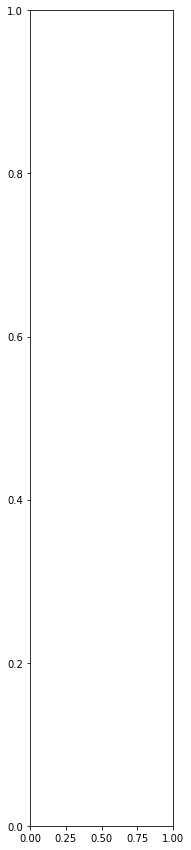

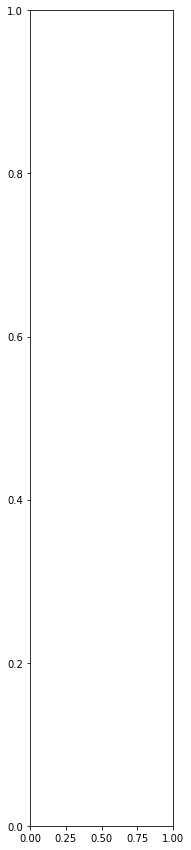

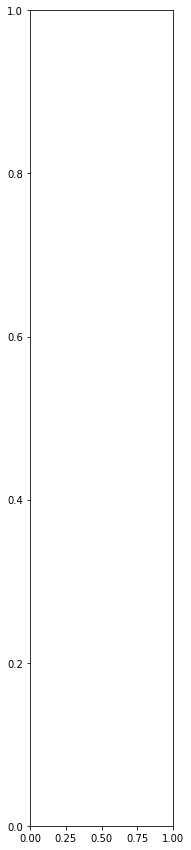

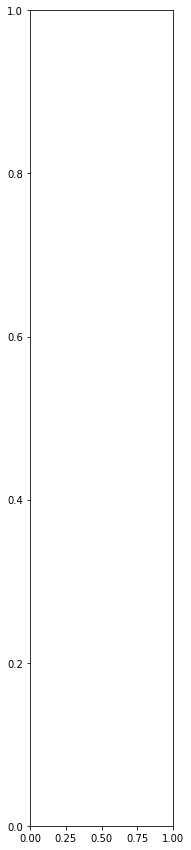

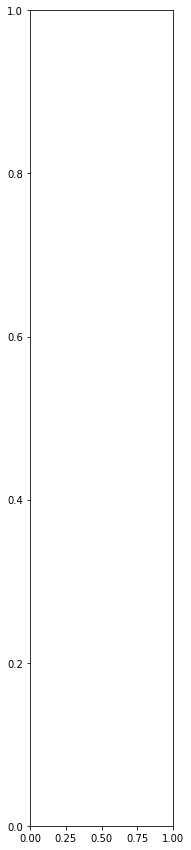

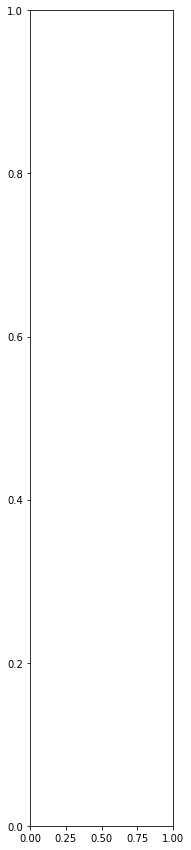

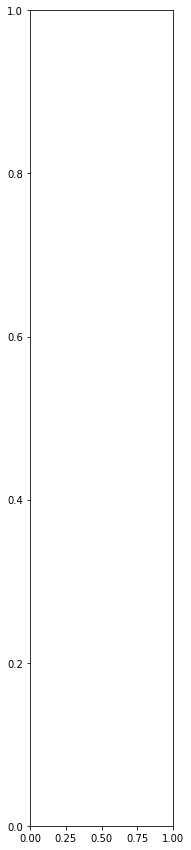

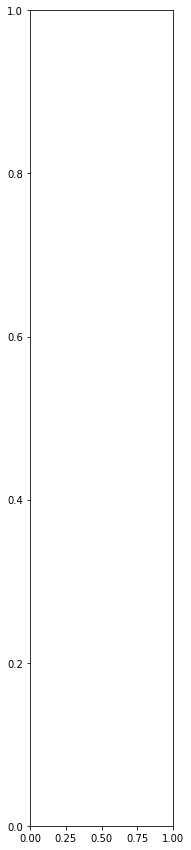

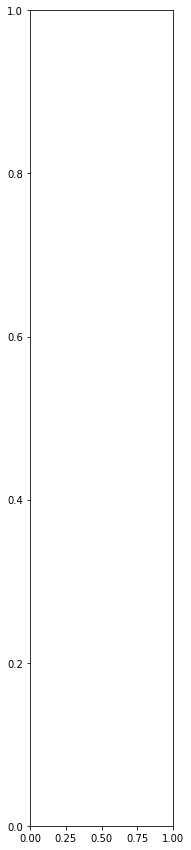

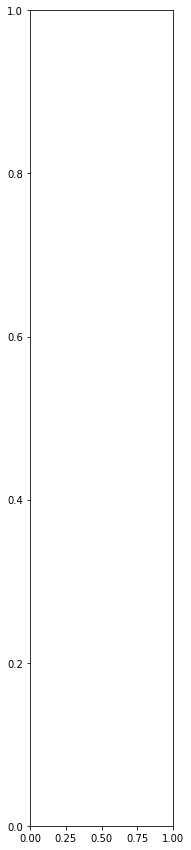

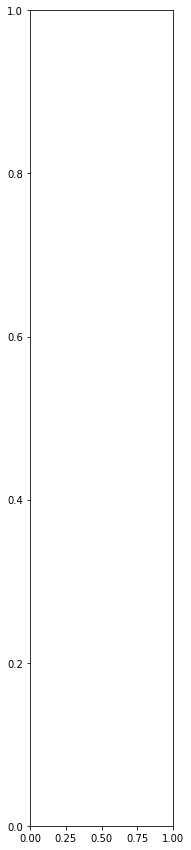

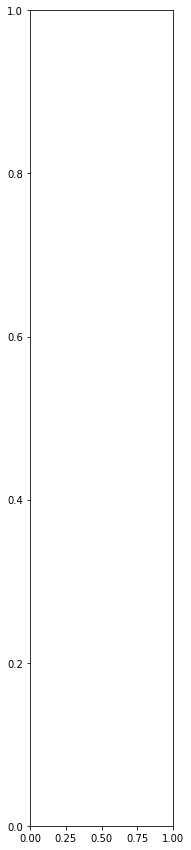

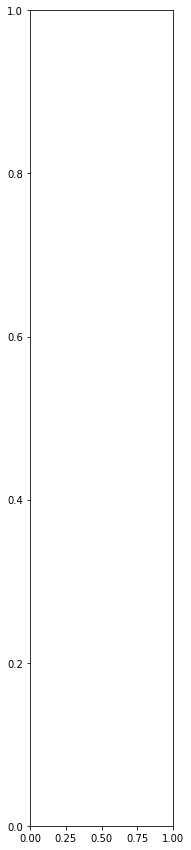

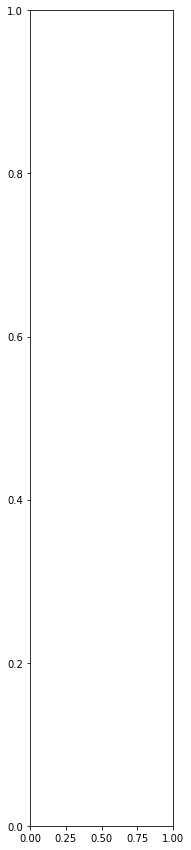

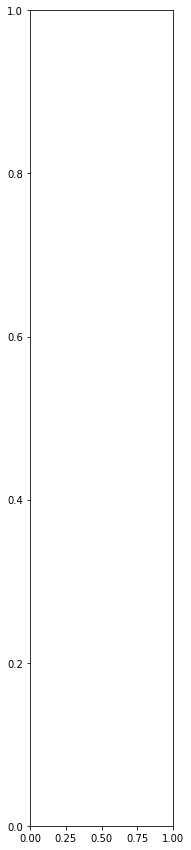

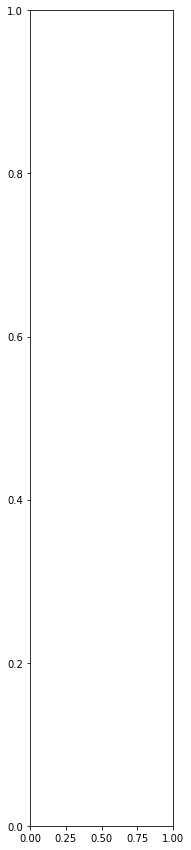

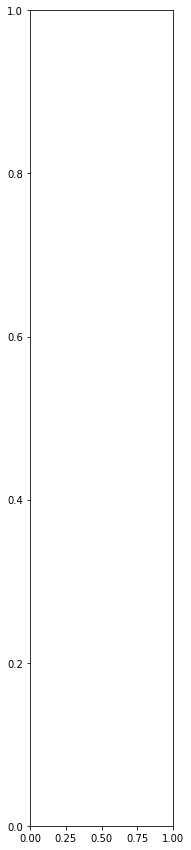

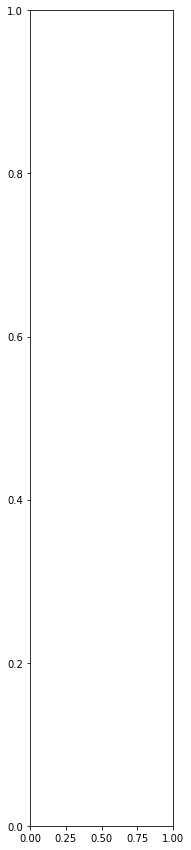

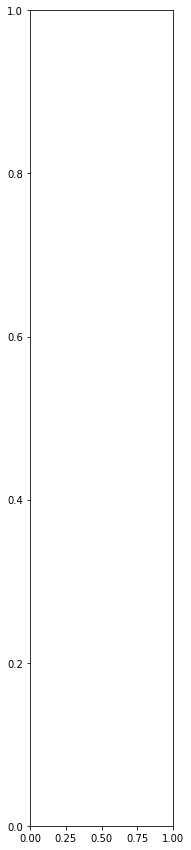

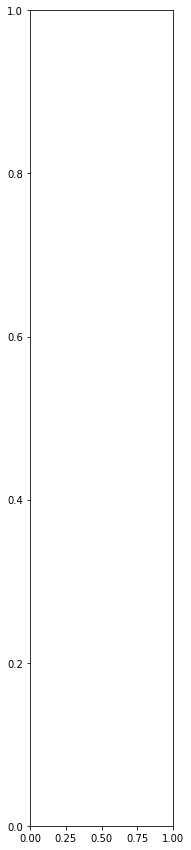

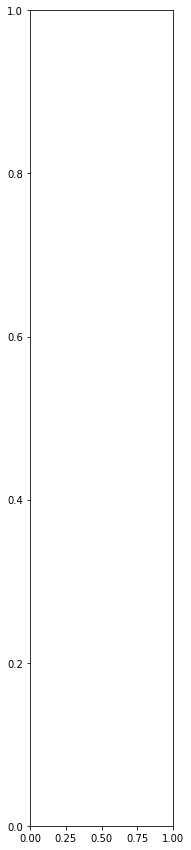

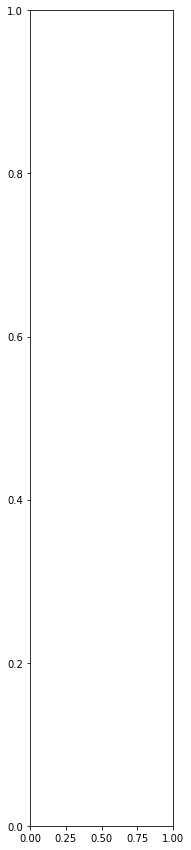

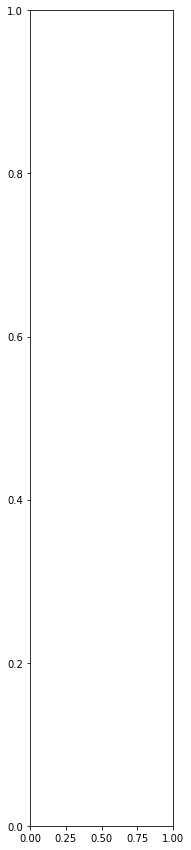

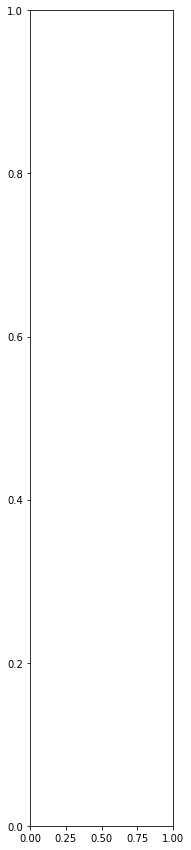

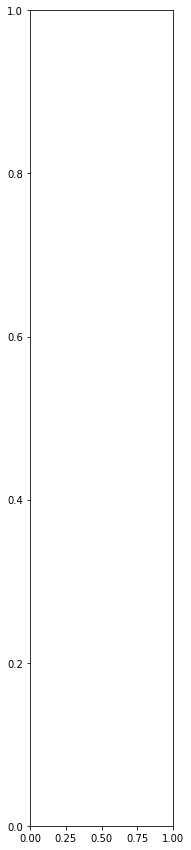

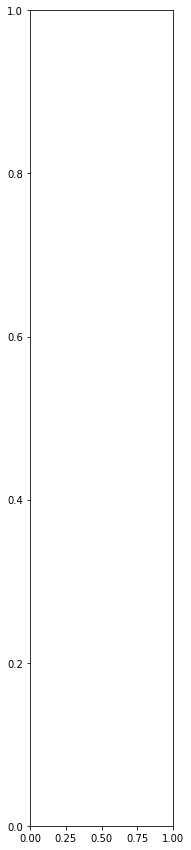

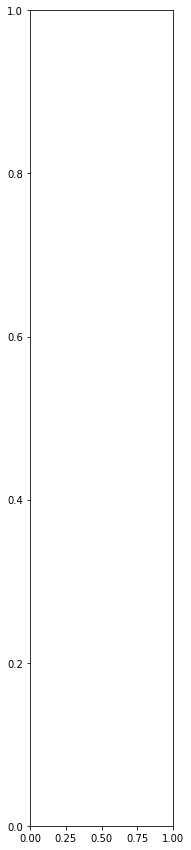

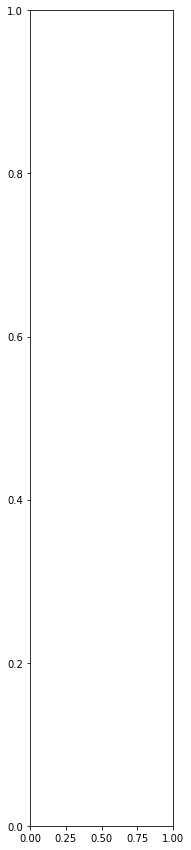

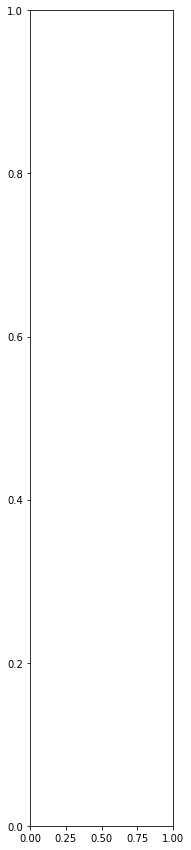

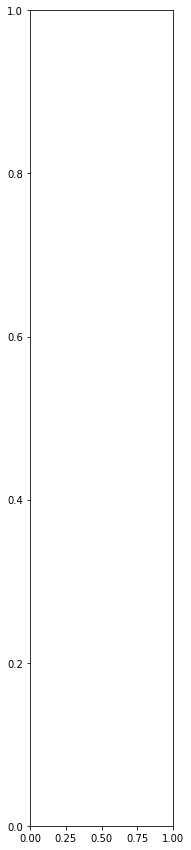

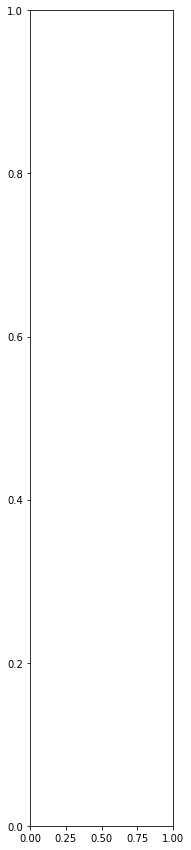

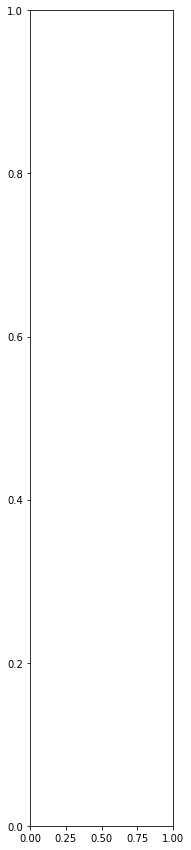

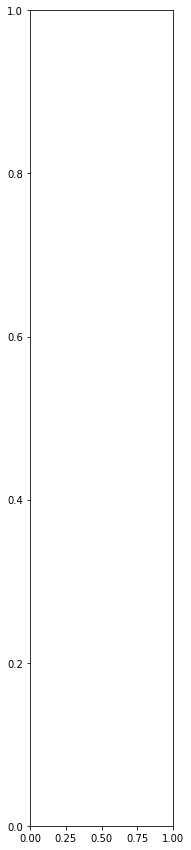

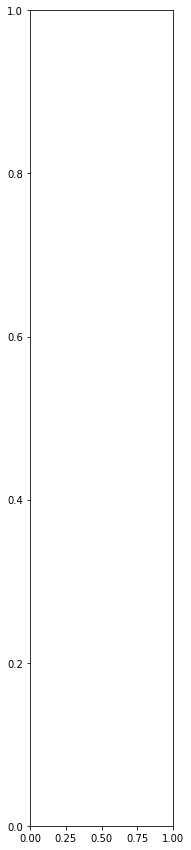

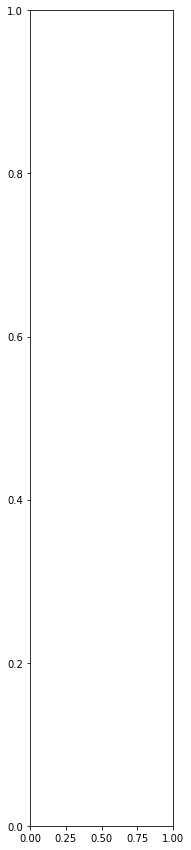

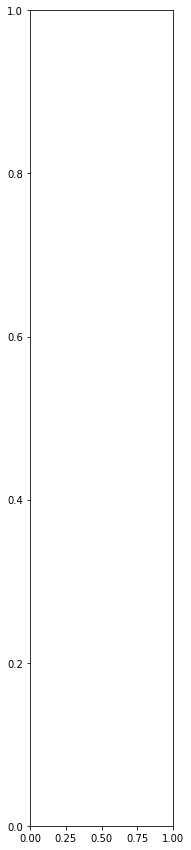

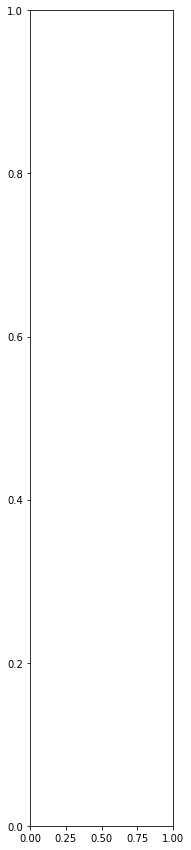

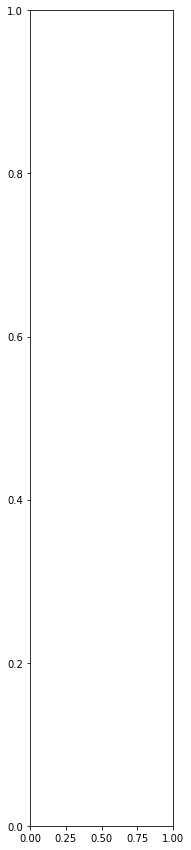

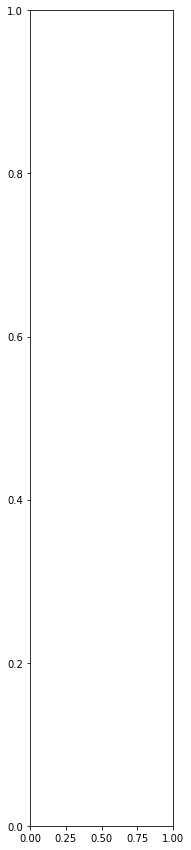

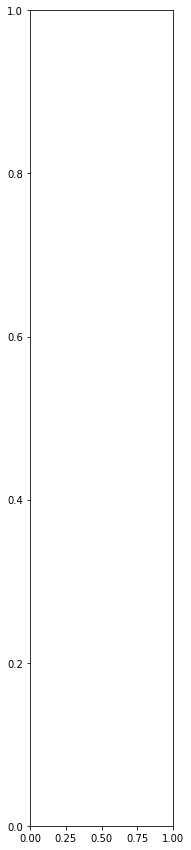

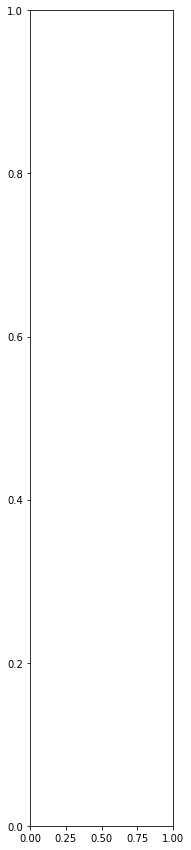

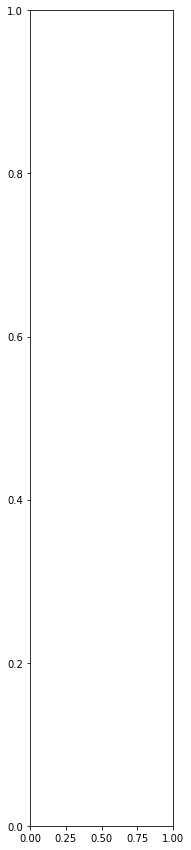

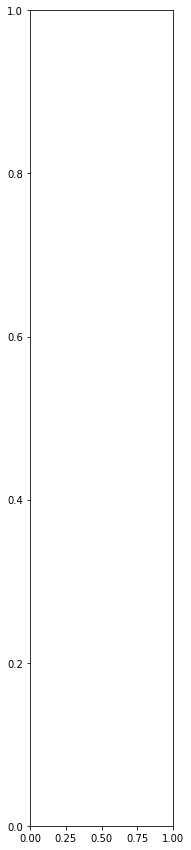

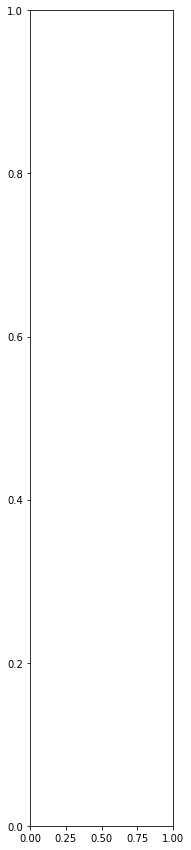

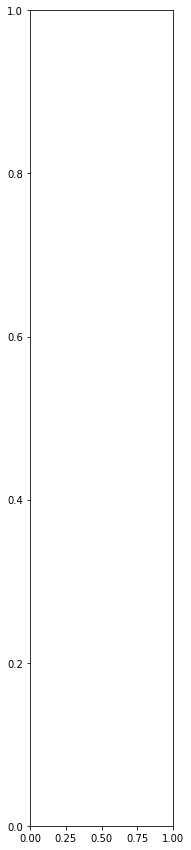

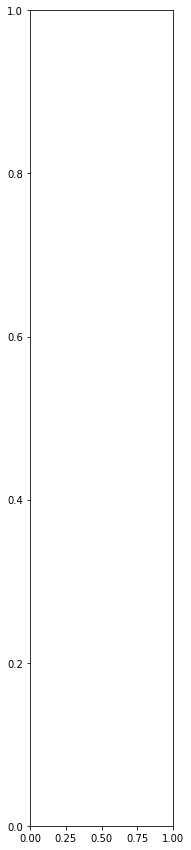

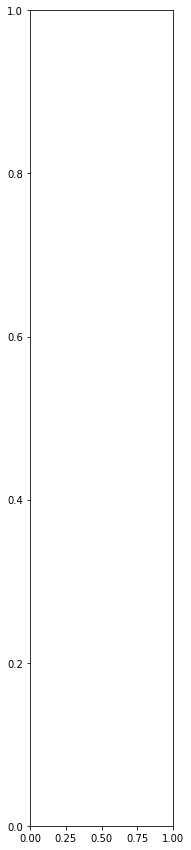

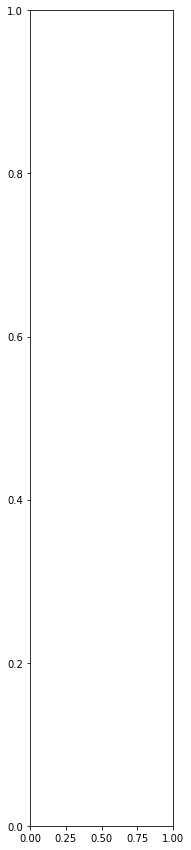

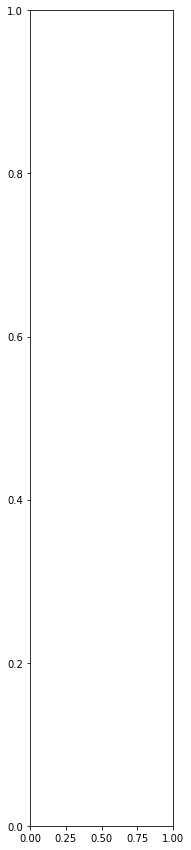

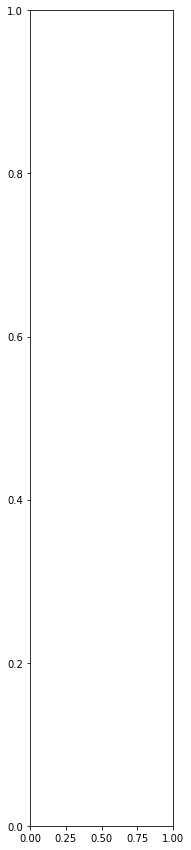

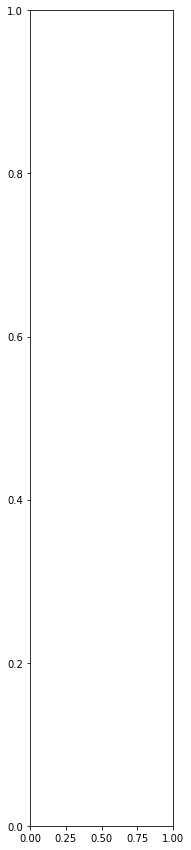

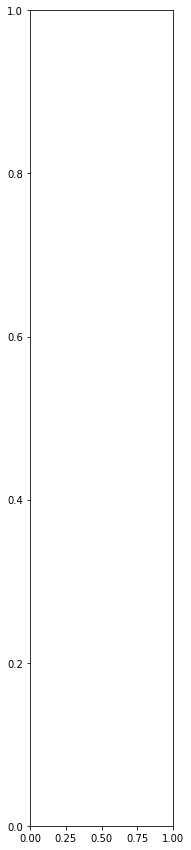

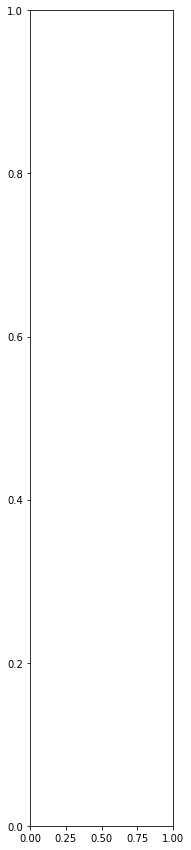

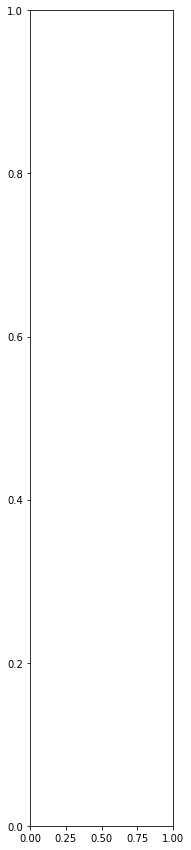

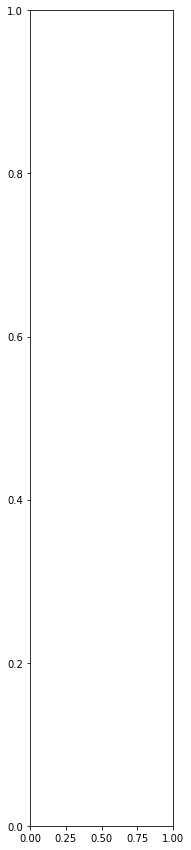

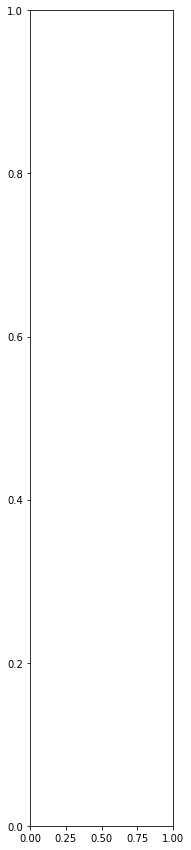

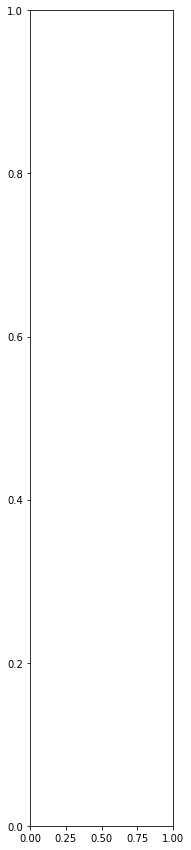

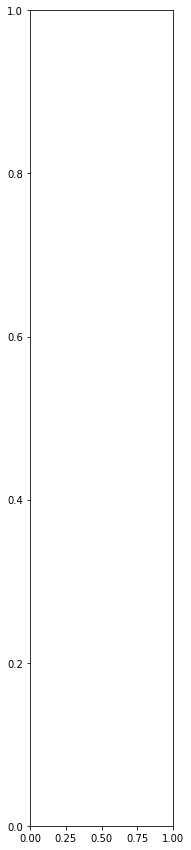

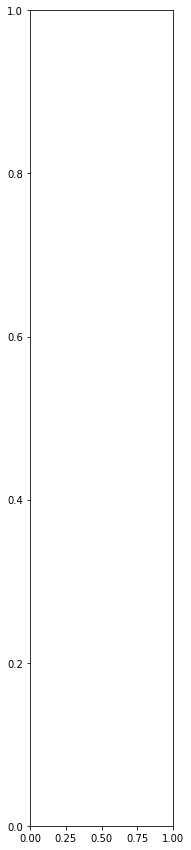

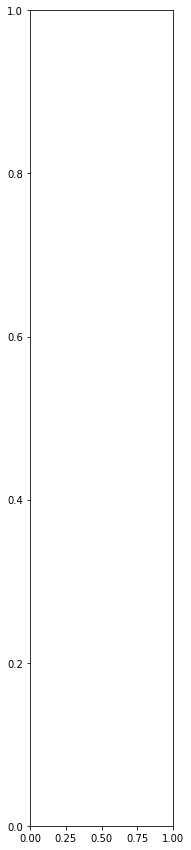

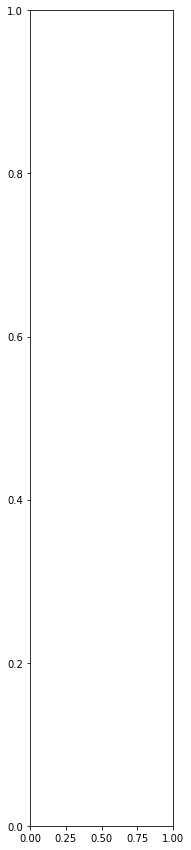

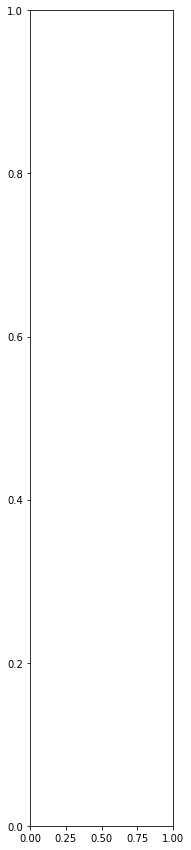

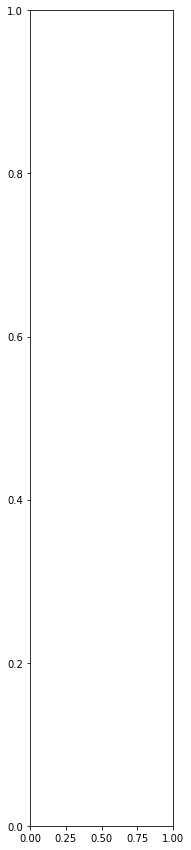

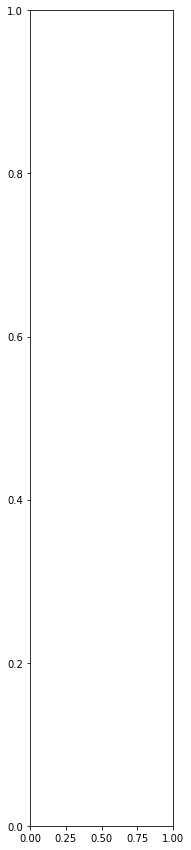

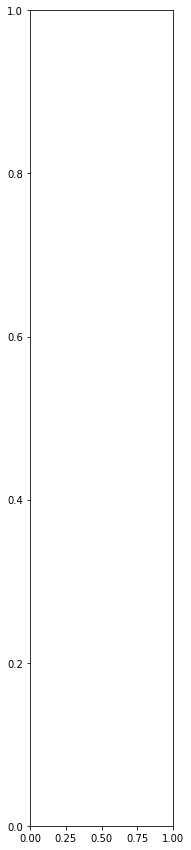

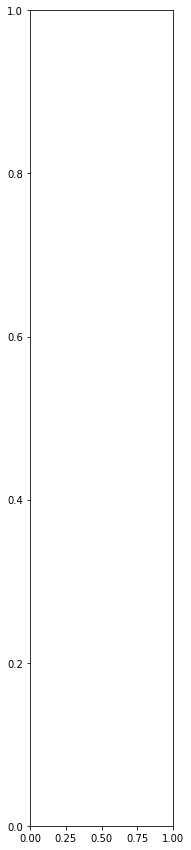

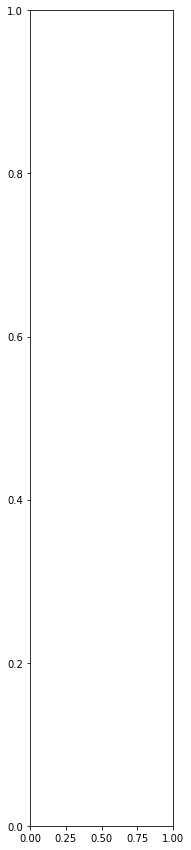

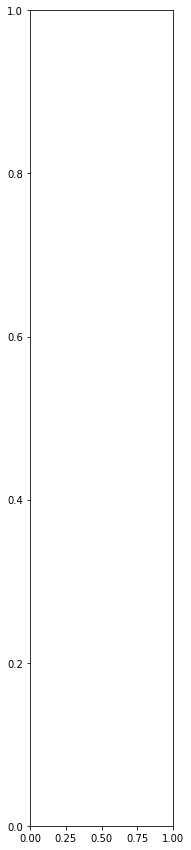

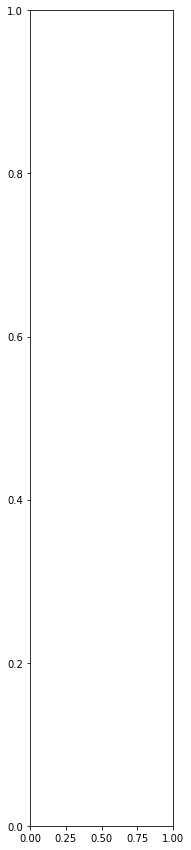

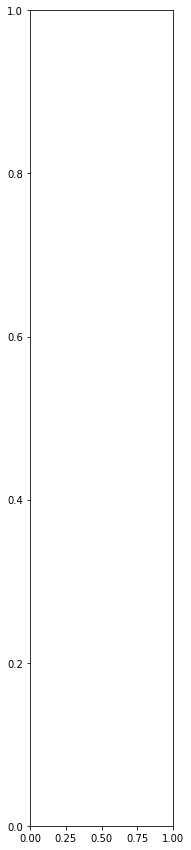

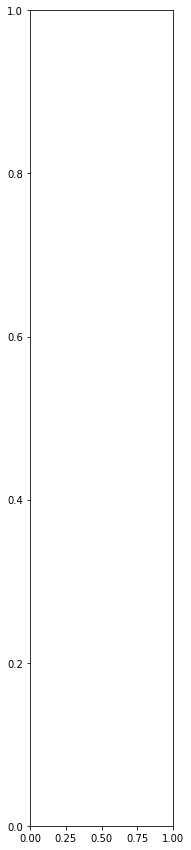

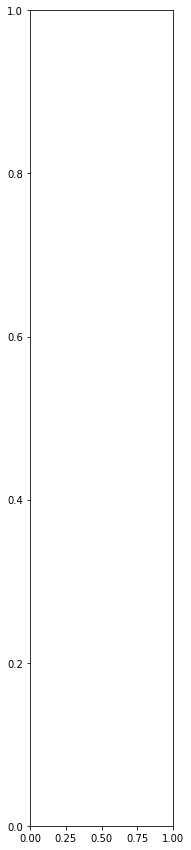

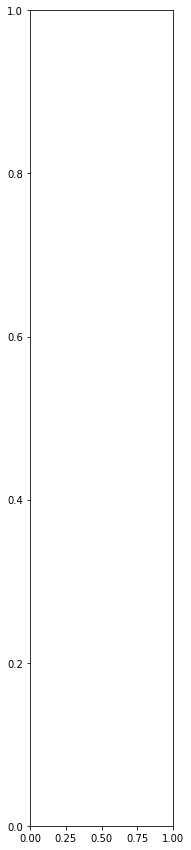

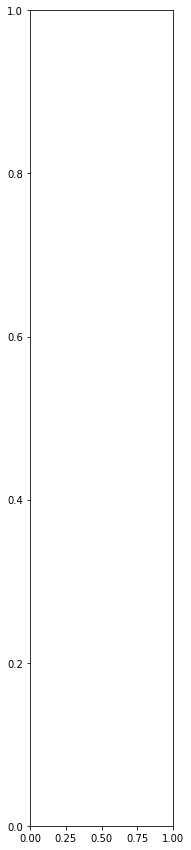

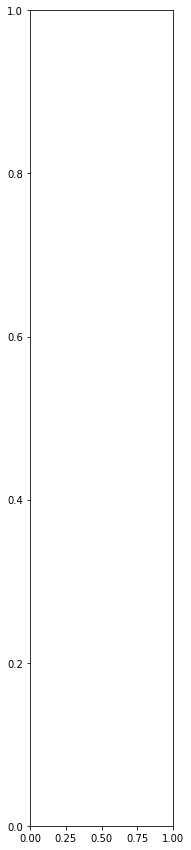

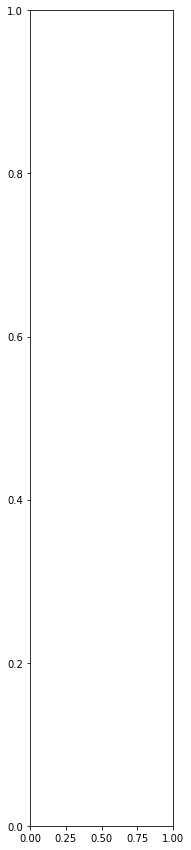

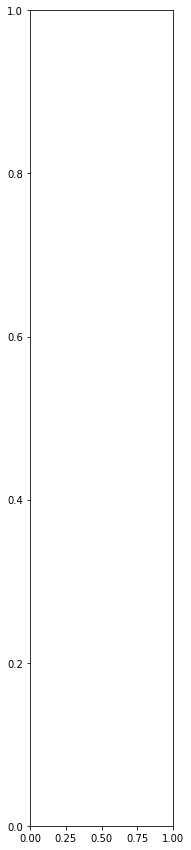

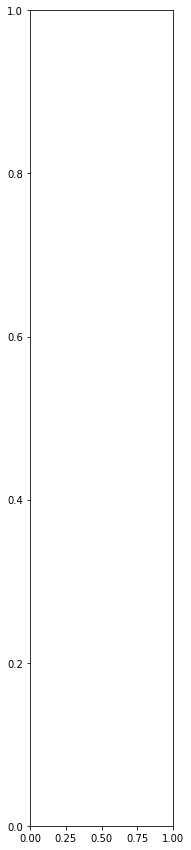

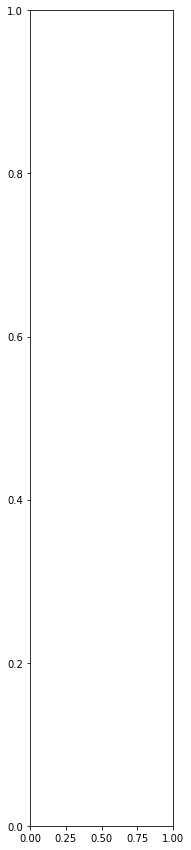

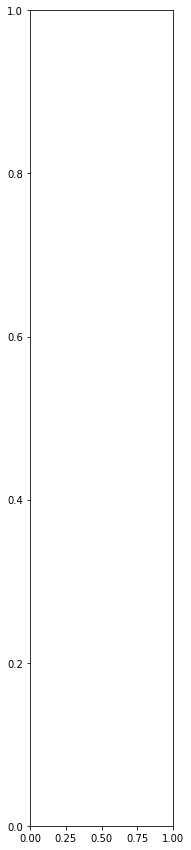

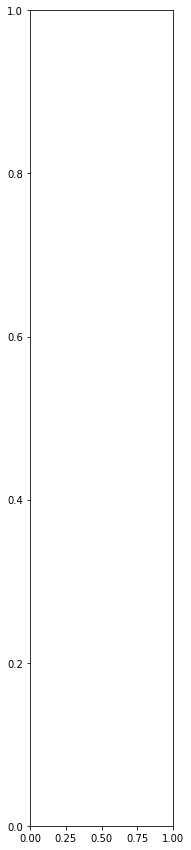

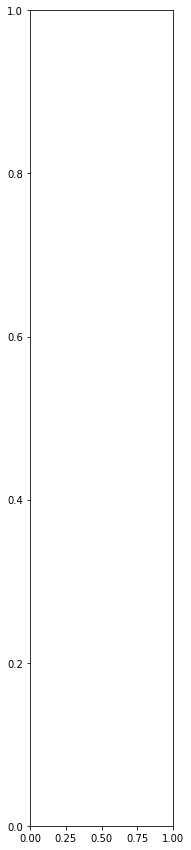

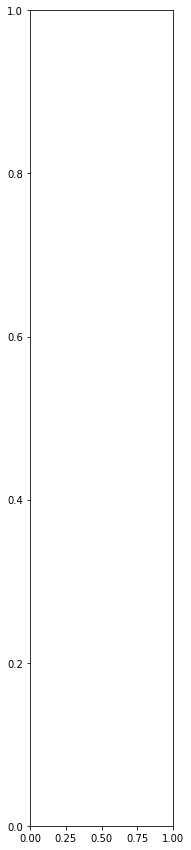

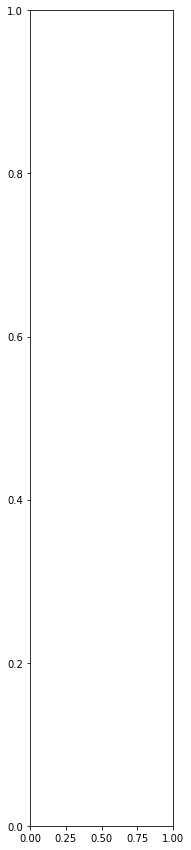

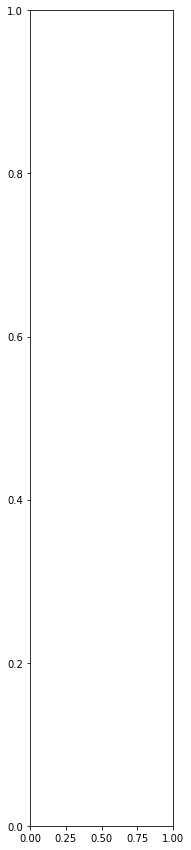

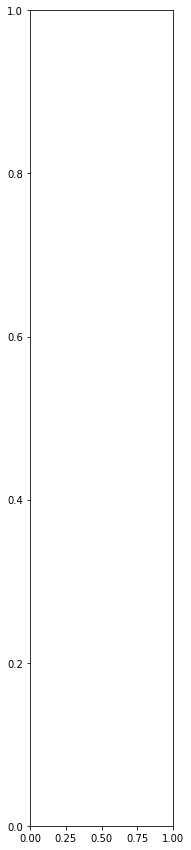

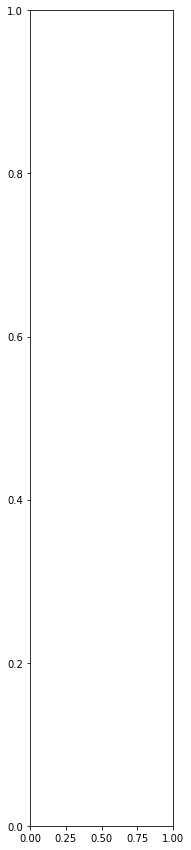

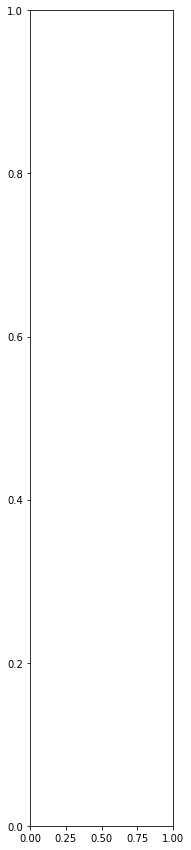

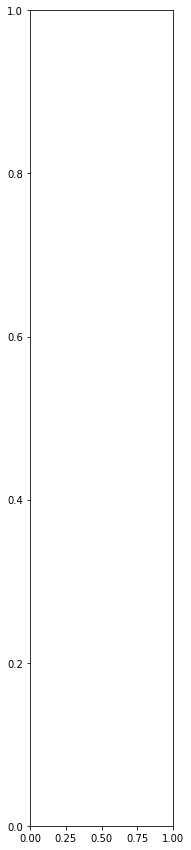

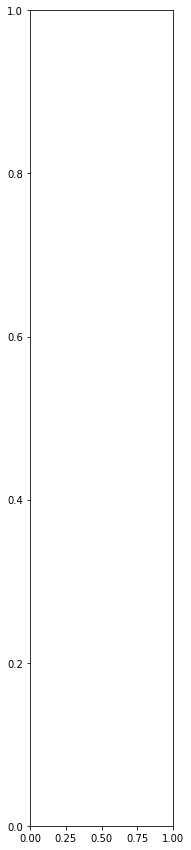

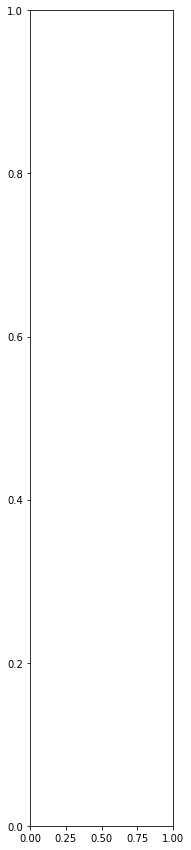

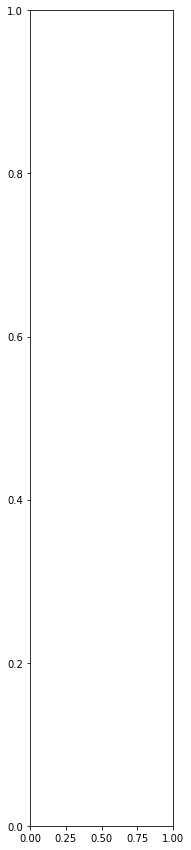

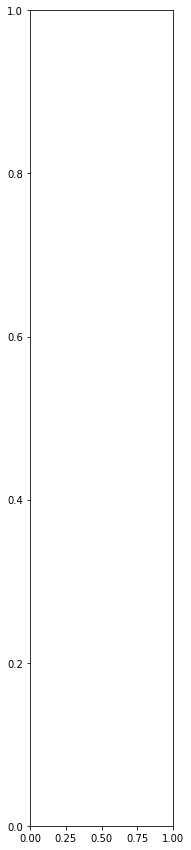

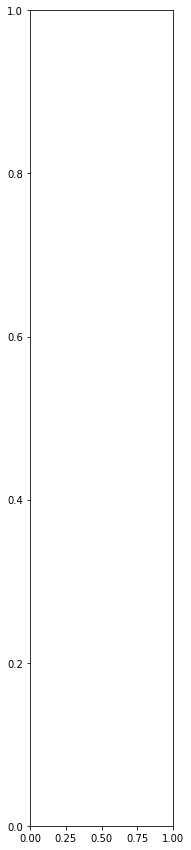

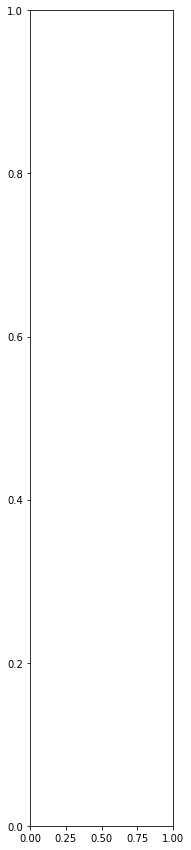

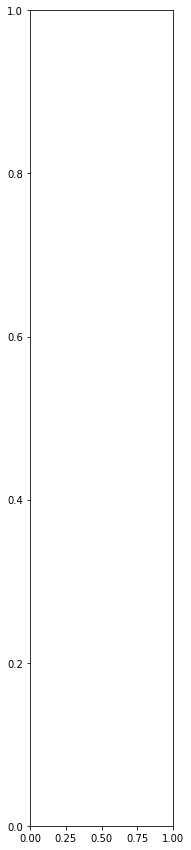

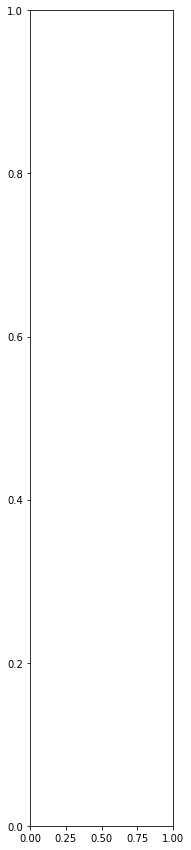

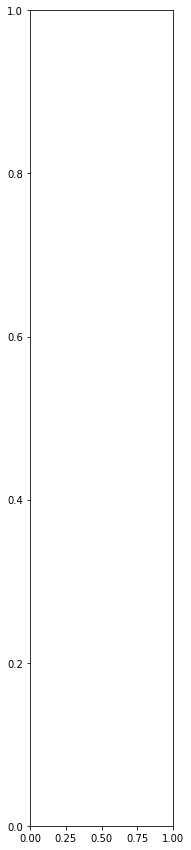

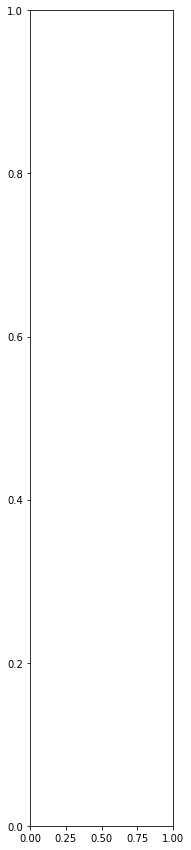

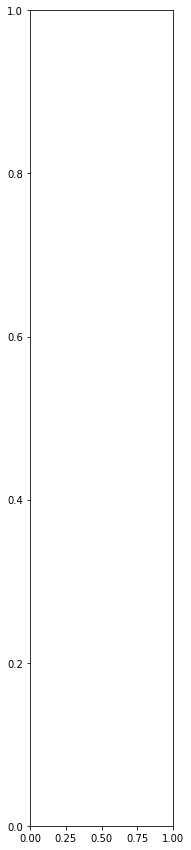

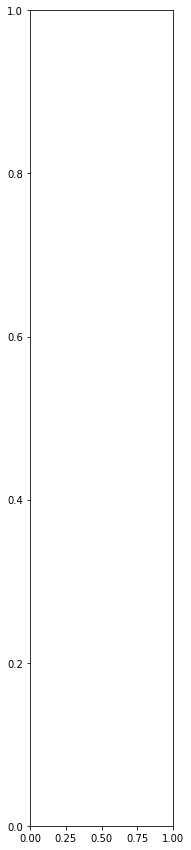

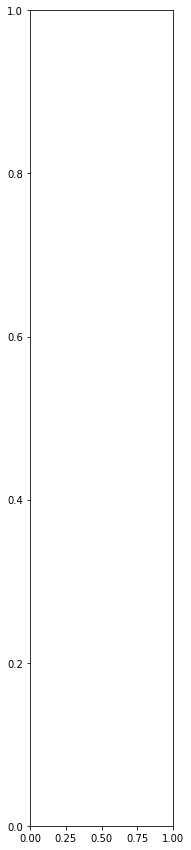

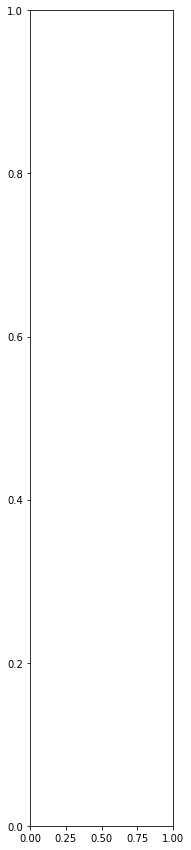

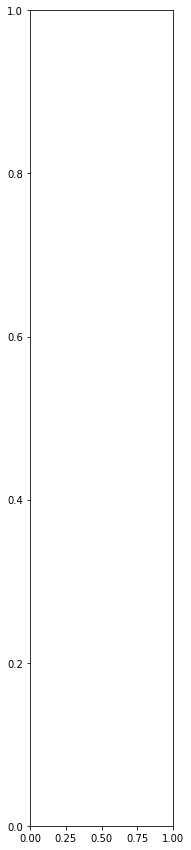

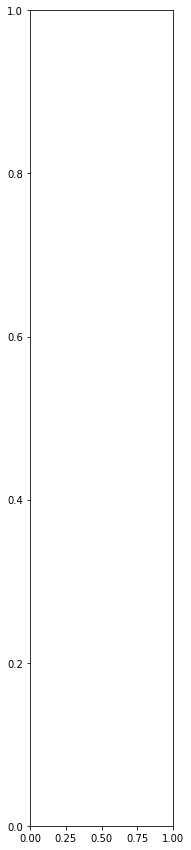

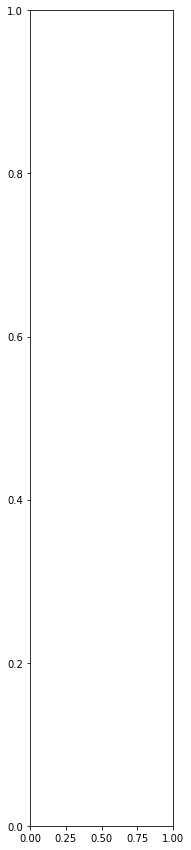

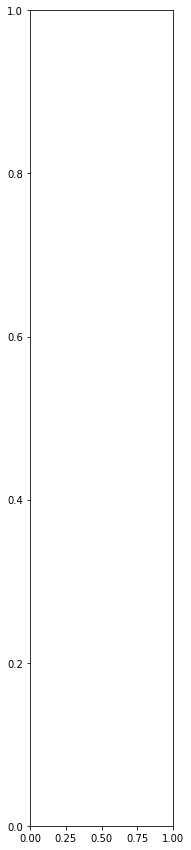

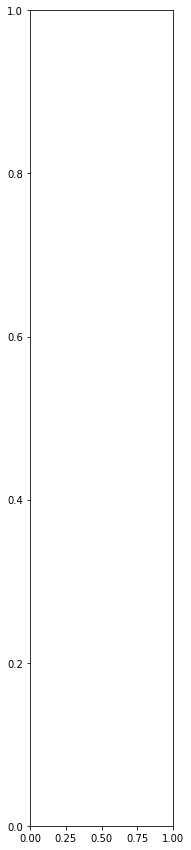

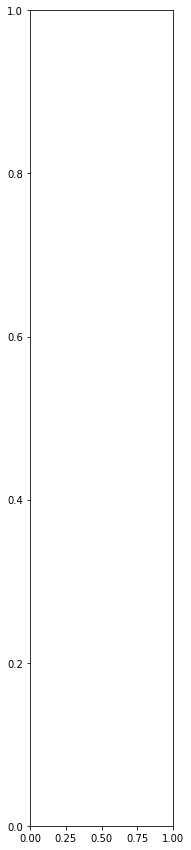

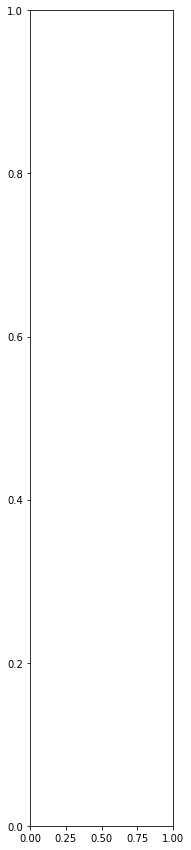

In [32]:
### 예측 결과 시각화

@interact(index = (0, min_num_files - 1))
def show_result(index = 0):
    # 테스트 이미지 파일 가져오기
    angry_image = get_RGB_image(test_data_dir, test_angry_imgs[index])
    disgust_image = get_RGB_image(test_data_dir, test_disgust_imgs[index])
    fear_image = get_RGB_image(test_data_dir, test_fear_imgs[index])
    happy_image = get_RGB_image(test_data_dir, test_happy_imgs[index])
    neutral_image = get_RGB_image(test_data_dir, test_neutral_imgs[index])
    sad_image = get_RGB_image(test_data_dir, test_sad_imgs[index])
    surprise_image = get_RGB_image(test_data_dir, test_surprise_imgs[index])
    
    # 예측
    prediction_1 = model_predict(angry_image, model)
    prediction_2 = model_predict(disgust_image, model)
    prediction_3 = model_predict(fear_image, model)
    prediction_4 = model_predict(happy_image, model)
    prediction_5 = model_predict(neutral_image, model)
    prediction_6 = model_predict(sad_image, model)
    prediction_7 = model_predict(surprise_image, model)
    
    # 시각화
    plt.figure(figsize=(21, 15))
    plt.subplot(171)
    plt.title(f'Pred: {feelings_list[prediction_1]} | GT: Angry')
    plt.imshow(angry_image)
    plt.subplot(172)
    plt.title(f'Pred: {feelings_list[prediction_2]} | GT: Disgust')
    plt.imshow(disgust_image)
    plt.subplot(173)
    plt.title(f'Pred: {feelings_list[prediction_3]} | GT: Fear')
    plt.imshow(fear_image)
    plt.subplot(174)
    plt.title(f'Pred: {feelings_list[prediction_4]} | GT: Happy')
    plt.imshow(happy_image)
    plt.subplot(175)
    plt.title(f'Pred: {feelings_list[prediction_5]} | GT: Neutral')
    plt.imshow(neutral_image)
    plt.subplot(176)
    plt.title(f'Pred: {feelings_list[prediction_6]} | GT: Sad')
    plt.imshow(sad_image)
    plt.subplot(177)
    plt.title(f'Pred: {feelings_list[prediction_7]} | GT: Surprise')
    plt.imshow(surprise_image)
    plt.tight_layout()

- 이게 오류가 나서 확인이 안되네요.. 근데 지금 노트북으로 작업중이라 gpu가 없어서 수정 못해요..^-^;
- 7개의 클래스 중 3개 클래스(0,2,5) 정도만 다 답으로 예측하고, 특히 5를 답으로 찍는 비율이 압도적으로 높았는데, 클래스 5에 대한 가중치를 더 낮추면 accuracy가 올라가려나요?